# Example: Solving a Batch Bacterial Growth Model using Explicit Multiple-Step Methods
This example will familiarize students with working with [linear multistep methods, particularly the Adams–Bashforth family of methods](https://en.wikipedia.org/wiki/Linear_multistep_method) for the solution of a System of Nonlinear Differential Equations. In particular, we will explore a model for bacterial growth on a limiting carbon source (sugar) of the form:

$$
\begin{eqnarray}
\frac{dS}{dt} & = & -\frac{1}{Y}\cdot{r}_{g}\cdot{C}\\
\frac{dC}{dt} & = & \left(r_{g} - k_{d}\right)\cdot{C}
\end{eqnarray}
$$

where $S$ denotes the concentration of the limiting carbon source, e.g., glucose, $C$ denotes the cell mass concentration, $Y$ denotes the yields of cells per unit sugar, $r_{g}$ denotes the specific growth rate, and $k_{d}$ denotes the cell-death rate constant (units: 1/hr). We'll model the specific growth rate using the [Monod growth law](https://en.wikipedia.org/wiki/Monod_equation):

$$
r_{g} = \frac{\mu_{g}^{\text{max}}\cdot{S}}{K_{g}+S}
$$

where $\mu_{g}^{\text{max}}$ denotes the maximumn specific growth rate, and $K_{g}$ denotes the growth saturation constant.

## Setup
This example requires several external libraries and a function to compute the outer product. Let's download and install these packages and call our `Include.jl` file.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9c`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9c/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9c/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9c/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-9/L9c/Manifest.toml`


## Prerequisites
Before we do any computation, let's specify some constant values, namely, the step size $h$ (which controls how fine the time resolution is), the maximum specific growth rate $\mu_{g}^{\text{max}}$ (units: 1/hr), the saturation coefficient $K_{g}$ (g/L), the yield $Y$, etc.

In [2]:
μgmax = 1.03; # units 1/h
K = 0.01; # units g/L
Y = 0.52; # units gdw/g
kd = 0.01; # units: 1/hr
h = 0.001; # units N/A
T = 10.0; # units hours

## Setup the growth rate and balances functions
We'll call the growth rate and balances functions in our `solve(...)` method, passing in the state vector and the time index during each pass of the loop:

In [3]:
function μ(x::Array{Float64}; μgmax::Float64 = 0.0, K::Float64 = 0.0)

    # initialize -
    growth_rate = 0.0;
    S = x[1]; # we know that index 1 is S
    
    # compute the growth rate -
    growth_rate = (μgmax*S)/(K+S);
    
    # return -
    return growth_rate;
end;

In [4]:
function balances(x::Array{Float64,1}, i::Int64, p::Dict{String,Any})

    # initialize -
    rhs_vector = zeros(length(x));
    Y = p["Y"];
    μgmax = p["μgmax"];
    K = p["K"];
    kd = p["kd"];
    S = x[1]; # we know index 1 = S
    C = x[2]; # we know index 2 = C
    
    # compute the specific growth rate 
    rg = μ(x, μgmax = μgmax, K = K);

    # put stuff in rhs vector -
    rhs_vector[1] = -(1/Y)*rg*C;
    rhs_vector[2] = (rg - kd)*C;

    # return -
    return rhs_vector;
end;

## Build components needed to call the `solve(...)` function
Before we solve the batch growth problem, we need to set up the parameters for the model and various other constants needed for the problem, e.g., the initial conditions and the period we want to simulate.

In [5]:
xₒ = [0.5, 0.005]; # initial conditions;
tspan = (0.0,T,h);
parameters = Dict{String,Any}("μgmax" => μgmax, "K" => K, "Y" => Y, "kd" => kd);

## Call the `solve(...)` function to solve the system of equations
We've updated the signature of the `solve(...)` method that we originally developed in `Lab 9b` to be more like the standard ordinary differential equations package, the [DifferentialEquations.jl package](https://docs.sciml.ai/DiffEqDocs/stable/) which we'll use this afternoon, and in Problem Set 4.

```julia
function solve(balances::Function, tspan::Tuple{Float64,Float64,Float64}, initial::Array{Float64,1},
    parameters::Dict{String,Any}; solver::AbstractIVPSolverType = MyForwardEulerMethod())
```
* The new version of `solve(...)` takes the `balances::Function` as an argument, along with other data needed to solve the problem, i.e., the time span in the `tspan::Tuple{Float64, Float64, Float64}` argument, etc. Internally, we create a private instance of a `problem` container and pass it around to the `_solve(...)` implementations.
* For this problem, the `balances` function, which computes the right-hand side of the system of differential equations for the `bacterial growth` model, was defined in this notebook.
* The `solve(...)` method returns a `Tuple` containing the time vector and solution array (time on the rows, states on the columns). Let's save these values in the `T` and `X` variables, respectively.

In [6]:
method = build(MyAdamsBashforthMethod, (order = 4,));
#method = MyForwardEulerMethod();

In [10]:
method.b

Dict{Int64, Float64} with 4 entries:
  0 => -0.375
  2 => -2.45833
  3 => 2.29167
  1 => 1.54167

In [8]:
(T,X) = solve(balances, tspan, xₒ,parameters, solver=method);

### Visualize
`Unhide` the code block below to see how we plotted the estimated numerical solution for the batch culture Bacterial growth model.

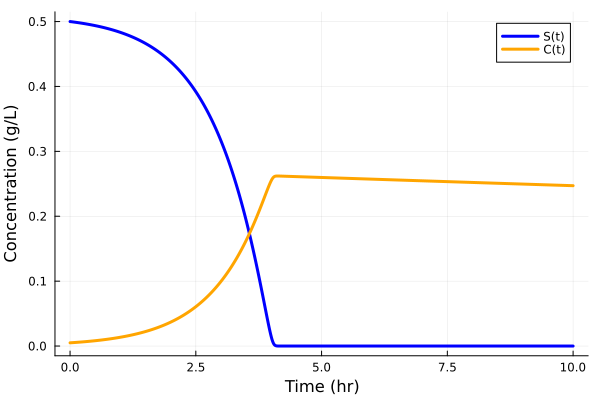

In [9]:
plot!(T,X[:,1], lw=3, label="S(t)", c=:blue)
plot!(T,X[:,2], lw=3, label="C(t)", c=:orange)
xlabel!("Time (hr)", fontsize=18)
ylabel!("Concentration (g/L)", fontsize=18)